In [3]:
# Librerías principaales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Libreriís de análisis estadístico y de series temporales
from datetime import datetime
from scipy import stats
from scipy.signal import find_peaks
import os

# Estilos de visualización con seaborn
sns.set(style="whitegrid")
sns.set_palette("husl")

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("="*60)
print("ANÁLISIS CLIMÁTICO: TENDENCIAS CO₂ Y TEMPERATURA GLOBAL")
print("="*60)

ANÁLISIS CLIMÁTICO: TENDENCIAS CO₂ Y TEMPERATURA GLOBAL


In [4]:
# ===============================================
# FASE 1: PREPARACIÓN Y UNIFICACIÓN DE DATOS
# ===============================================

In [5]:
# 1.1 Carga de datasets originales
df_temp = pd.read_csv("../data/raw/global_temperature.csv", skiprows=4)  # puede variar según el archivo exacto
df_co2 = pd.read_csv("../data/raw/co2_monthly.csv", comment='#') # Ignorar líneas de comentarios
print(f"Dataset temperatura: {df_temp.shape}")
print(f"Dataset CO2: {df_co2.shape}")

Dataset temperatura: (176, 2)
Dataset CO2: (808, 8)


In [6]:
# 1.2 Limpieza dataset CO2

# Crear columna 'date' a partir de 'year' y 'month'
df_co2["date"] = pd.to_datetime(df_co2["year"].astype(str) + "-" + df_co2["month"].astype(str), errors='coerce')
df_co2 = df_co2.set_index("date", inplace=False)

# Seleccionar columnas relevantes
df_co2_clean = df_co2[['year', 'month', 'average']].copy()
print(f"CO2 Limpio: {df_co2_clean.shape}")

CO2 Limpio: (808, 3)


In [7]:
#1.3 Agregar CO2  por año (promedio anual)

df_co2_anual = df_co2_clean.groupby('year')['average'].mean().reset_index()
df_co2_anual.columns = ['Year', 'co2_avg']
print(f"CO2 anual: {df_co2_anual.shape}")

CO2 anual: (68, 2)


In [8]:
#1.4 Unificar datasets por año
df_comb = pd.merge(df_temp, df_co2_anual, on='Year', how='inner')
print(f"Dataset combinado: {df_comb.shape} (período: {df_comb['Year'].min()}-{df_comb['Year'].max()})")

Dataset combinado: (68, 3) (período: 1958-2025)


In [9]:
# 1.5 Creación de variables derivadas
print("\nVariables derivadas.")
# Columna década
df_comb['decade'] = (df_comb['Year'] // 10) * 10

# Ordenar por año para cálculos temporales
df_comb = df_comb.sort_values('Year'). reset_index(drop=True)

# Tasas de cambio y aceleración
#Primera derivada (cambio año a año) - si el cambio es rápido o lento
df_comb['temp_change'] = df_comb['Anomaly'].diff()
df_comb['co2_change'] = df_comb['co2_avg'].diff()
# Segunda derivada (aceleración) - si el cambio se está acelerando o desacelerando
df_comb['temp_acceleration'] = df_comb['temp_change'].diff()
df_comb['co2_acceleration'] = df_comb['co2_change'].diff()

# Tendencias móviles (ventana de 10 años) - para suavizar las series y ver tendencias a largo plazo
window = 10
df_comb['temp_trend'] = df_comb['Anomaly'].rolling(window=window).apply(
    lambda x: stats.linregress(range(len(x)), x).slope if len(x) == window else np.nan
)
df_comb['co2_trend'] = df_comb['co2_avg'].rolling(window=window).apply(
    lambda x: stats.linregress(range(len(x)), x).slope if len(x) == window else np.nan
)

print(f"Variables finales: {list(df_comb.columns)}")
print(f"Correlación CO2-Temperatura: {df_comb['Anomaly'].corr(df_comb['co2_avg']):.4f}")



Variables derivadas.
Variables finales: ['Year', 'Anomaly', 'co2_avg', 'decade', 'temp_change', 'co2_change', 'temp_acceleration', 'co2_acceleration', 'temp_trend', 'co2_trend']
Correlación CO2-Temperatura: 0.9565


In [10]:
# 1.6 Guardar datasets limpios y combinados
df_temp.to_csv("../data/clean/global_temperature_clean.csv", index=False)
df_co2 = df_co2.reset_index(names="date") # esto es para que la fecha no sea el índice al guardar
df_co2.to_csv("../data/clean/co2_clean.csv", index=False) #guardar el dataset limpio con 'date' visible
df_comb.to_csv("../data/clean/combined_climate_data.csv", index=False) #guardar el dataset combinado

In [11]:
# ===============================================
# FASE 2: ANÁLISIS EXPLORATORIO INTEGRAL (EDA)
# ===============================================

In [12]:
# 2.1 Estadisticas descriptivas básicas
print("Estadísticas descriptivas básicas:")
desc_starts = df_comb[['Year', 'Anomaly', 'co2_avg']].describe().round(3)
print(desc_starts)

Estadísticas descriptivas básicas:
           Year  Anomaly  co2_avg
count    68.000   68.000   68.000
mean   1991.500    0.402  360.593
std      19.774    0.331   33.165
min    1958.000   -0.090  315.237
25%    1974.750    0.100  330.895
50%    1991.500    0.375  356.125
75%    2008.250    0.673  386.285
max    2025.000    1.210  428.608


In [13]:
# 2.2 Análisis por décadas
print("\nAnálisis por décadas:")
decade_stats = df_comb.groupby('decade').agg({
    'Anomaly': ['mean', 'min', 'max', 'std'],
    'co2_avg': ['mean', 'min', 'max', 'std'],
    'temp_change': 'mean',
    'co2_change': 'mean'
}).round(4)

decade_stats.columns = ['_'.join(col).strip() for col in decade_stats.columns]
print(decade_stats[['Anomaly_mean', 'co2_avg_mean', 'temp_change_mean', 'co2_change_mean']])


Análisis por décadas:
        Anomaly_mean  co2_avg_mean  temp_change_mean  co2_change_mean
decade                                                               
1950          0.0700      315.6093             0.060           0.7447
1960          0.0190      320.2872             0.000           0.8639
1970          0.0860      330.8582             0.010           1.2214
1980          0.2500      345.6548             0.002           1.6370
1990          0.4450      360.5845             0.019           1.5335
2000          0.5510      378.7735             0.027           1.9103
2010          0.7680      400.4106             0.024           2.4007
2020          0.9983      420.5740             0.010           2.8265


In [14]:
print(f"Año mínimo: {df_comb['Year'].min()}")
print(f"Año máximo: {df_comb['Year'].max()}")
print(f"Total años: {df_comb['Year'].max() - df_comb['Year'].min() + 1}")

Año mínimo: 1958
Año máximo: 2025
Total años: 68


In [15]:
# 2.3 Análisis de regímenes climáticos
periods = {
    'Pre-industrial (1958-1970)': (1958, 1970),
    'Industrialización (1970-1990)': (1970, 1990),
    'Aceleración (1990-2010)': (1990, 2010),
    'Crisis climática (2010-2023)': (2010, 2023)
}

regime_analysis = {}
for period_name, (start, end) in periods.items():
    period_data = df_comb[(df_comb['Year'] >= start) & (df_comb['Year'] <= end)]

    if len(period_data) > 1:
        temp_slope = stats.linregress(period_data['Year'], period_data['Anomaly']).slope
        co2_slope = stats.linregress(period_data['Year'], period_data['co2_avg']).slope

        regime_analysis[period_name] = {
            'temp_slope': temp_slope,
            'co2_slope': co2_slope,
            'temp_mean': period_data['Anomaly'].mean(),
            'co2_mean': period_data['co2_avg'].mean(),
            'correlation': period_data['Anomaly'].corr(period_data['co2_avg'])
        }

regime_df = pd.DataFrame(regime_analysis).T.round(4)
print("\nAnálisis por regímenes:")
print(regime_df)


Análisis por regímenes:
                               temp_slope  co2_slope  temp_mean  co2_mean  \
Pre-industrial (1958-1970)        -0.0035     0.8292     0.0269  319.9825   
Industrialización (1970-1990)      0.0159     1.4757     0.1786  339.0277   
Aceleración (1990-2010)            0.0135     1.8336     0.5081  370.6515   
Crisis climática (2010-2023)       0.0262     2.4380     0.8200  405.3098   

                               correlation  
Pre-industrial (1958-1970)         -0.1585  
Industrialización (1970-1990)       0.6738  
Aceleración (1990-2010)             0.6346  
Crisis climática (2010-2023)        0.8852  


In [16]:
# 2.4 Correlaciones con rezagos
print("\nAnálisis de correlaciones temporales:")
max_lag = 5
lag_correlations = []

for lag in range(max_lag + 1):
    if lag == 0:
        corr = df_comb['Anomaly'].corr(df_comb['co2_avg'])
    else:
        corr = df_comb['Anomaly'].corr(df_comb['co2_avg'].shift(lag))

    lag_correlations.append({'lag': lag, 'correlation': corr})
    print(f"Lag {lag}: {corr:.4f}")

lag_df = pd.DataFrame(lag_correlations)


Análisis de correlaciones temporales:
Lag 0: 0.9565
Lag 1: 0.9542
Lag 2: 0.9560
Lag 3: 0.9554
Lag 4: 0.9555
Lag 5: 0.9537


In [17]:
# 2.5 Detección de outliers
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_temp = detect_outliers_iqr(df_comb, 'Anomaly')
outliers_co2 = detect_outliers_iqr(df_comb, 'co2_avg')

print(f"\nOutliers detectados:")
print(f"Temperatura: {len(outliers_temp)} outliers")
print(f"CO2: {len(outliers_co2)} outliers")


Outliers detectados:
Temperatura: 0 outliers
CO2: 0 outliers


In [18]:
# 2.6 Puntos de inflexión
temp_peaks, _ = find_peaks(df_comb['Anomaly'].values, height=0.5, distance=5)
temp_valleys, _ = find_peaks(-df_comb['Anomaly'].values, height=0.3, distance=5)

print(f"\nPuntos de inflexión:")
print(f"Picos temperatura: {df_comb.iloc[temp_peaks]['Year'].tolist()}")
print(f"Valles temperatura: {df_comb.iloc[temp_valleys]['Year'].tolist()}")


Puntos de inflexión:
Picos temperatura: [1991, 1998, 2005, 2010, 2015, 2024]
Valles temperatura: []


In [19]:
# ===============================================
# VISUALIZACIONES COMPLETAS
# ===============================================

In [20]:
print(f"\n📊 GENERANDO VISUALIZACIONES COMPLETAS...")


📊 GENERANDO VISUALIZACIONES COMPLETAS...


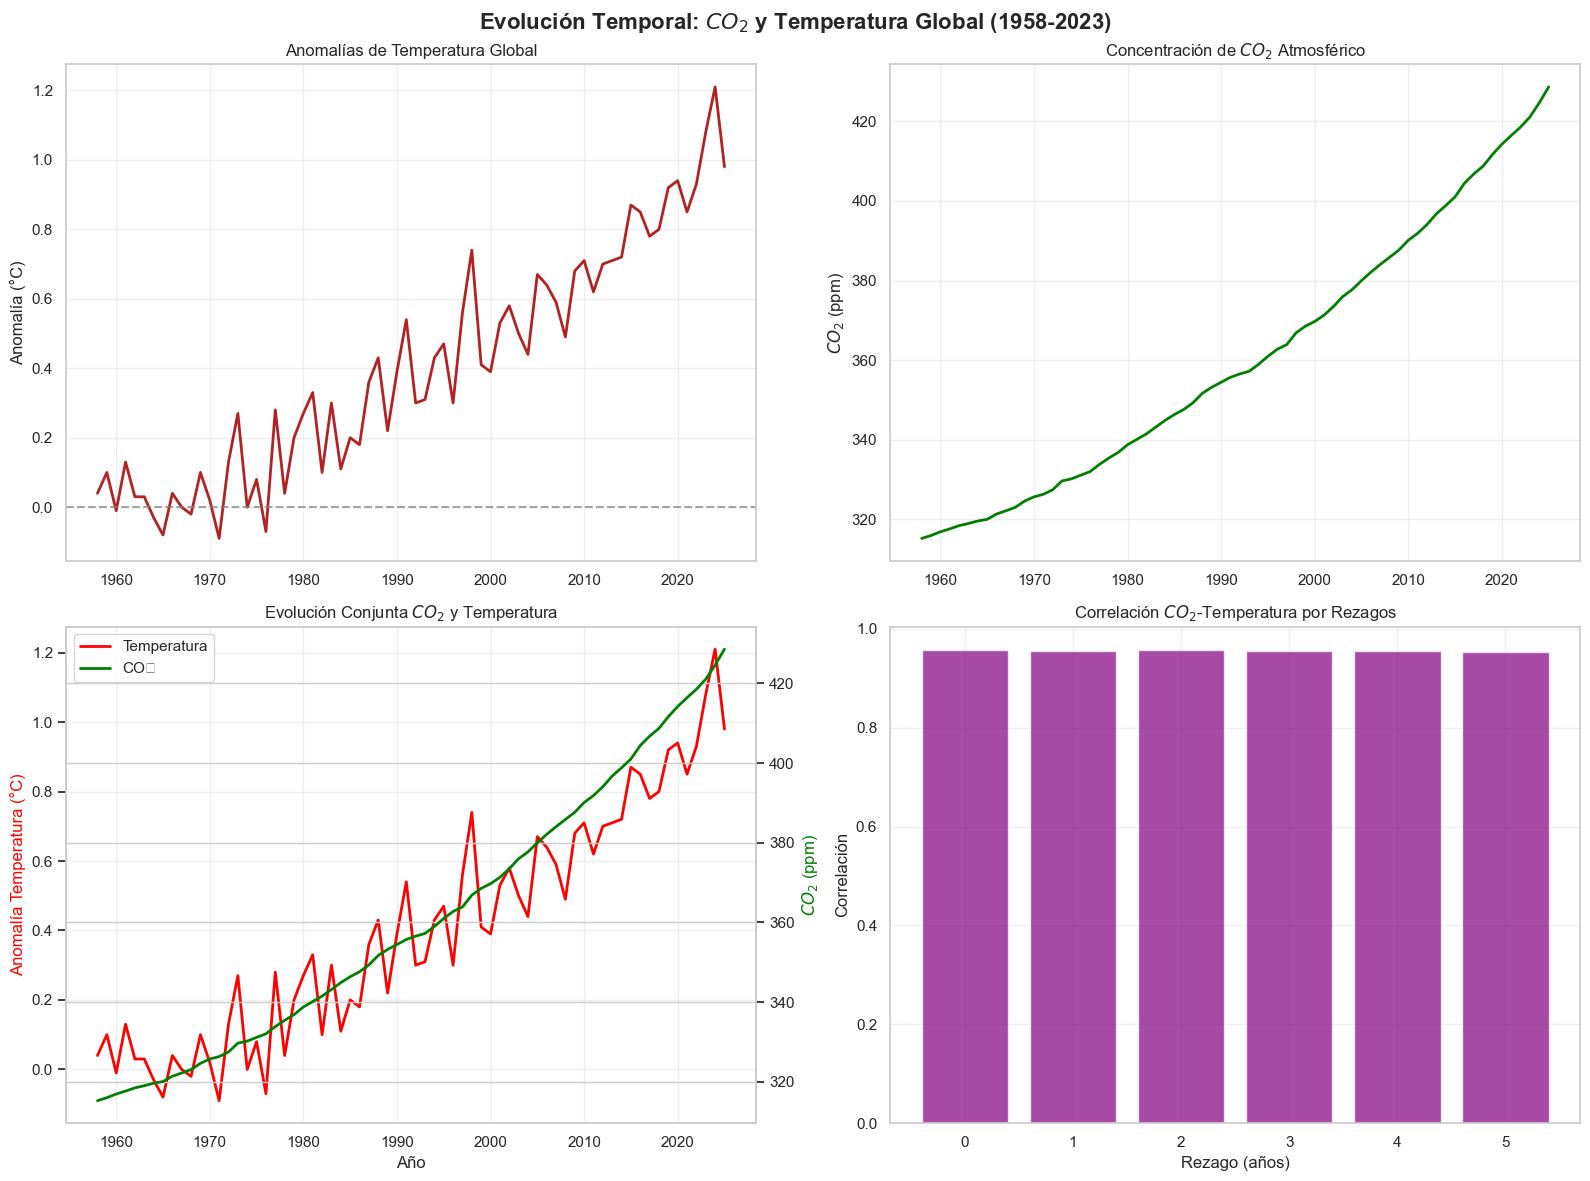

In [28]:
# Figura 1: Evolución temporal de temperatura y CO2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evolución Temporal: $CO_2$ y Temperatura Global (1958-2023)', fontsize=16, fontweight='bold')

# Subplot 1: Temperatura
axes[0,0].plot(df_comb['Year'], df_comb['Anomaly'], color='firebrick', linewidth=2)
axes[0,0].axhline(0, color='gray', linestyle='--', alpha=0.7)
axes[0,0].set_title('Anomalías de Temperatura Global')
axes[0,0].set_ylabel('Anomalía (°C)')
axes[0,0].grid(True, alpha=0.3)

# Subplot 2: CO2
axes[0,1].plot(df_comb['Year'], df_comb['co2_avg'], color='green', linewidth=2)
axes[0,1].set_title('Concentración de $CO_2$ Atmosférico')
axes[0,1].set_ylabel('$CO_2$ (ppm)')
axes[0,1].grid(True, alpha=0.3)

# Subplot 3: Comparación conjunta (ejes duales)
ax1 = axes[1,0]
ax2 = ax1.twinx()

line1 = ax1.plot(df_comb['Year'], df_comb['Anomaly'], color='red', linewidth=2, label='Temperatura')
line2 = ax2.plot(df_comb['Year'], df_comb['co2_avg'], color='green', linewidth=2, label='CO₂')

ax1.set_xlabel('Año')
ax1.set_ylabel('Anomalía Temperatura (°C)', color='red')
ax2.set_ylabel('$CO_2$ (ppm)', color='green')
ax1.set_title('Evolución Conjunta $CO_2$ y Temperatura')
ax1.grid(True, alpha=0.3)

# Leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Subplot 4: Correlación con rezagos
axes[1,1].bar(lag_df['lag'], lag_df['correlation'], color='purple', alpha=0.7)
axes[1,1].set_title('Correlación $CO_2$-Temperatura por Rezagos')
axes[1,1].set_xlabel('Rezago (años)')
axes[1,1].set_ylabel('Correlación')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


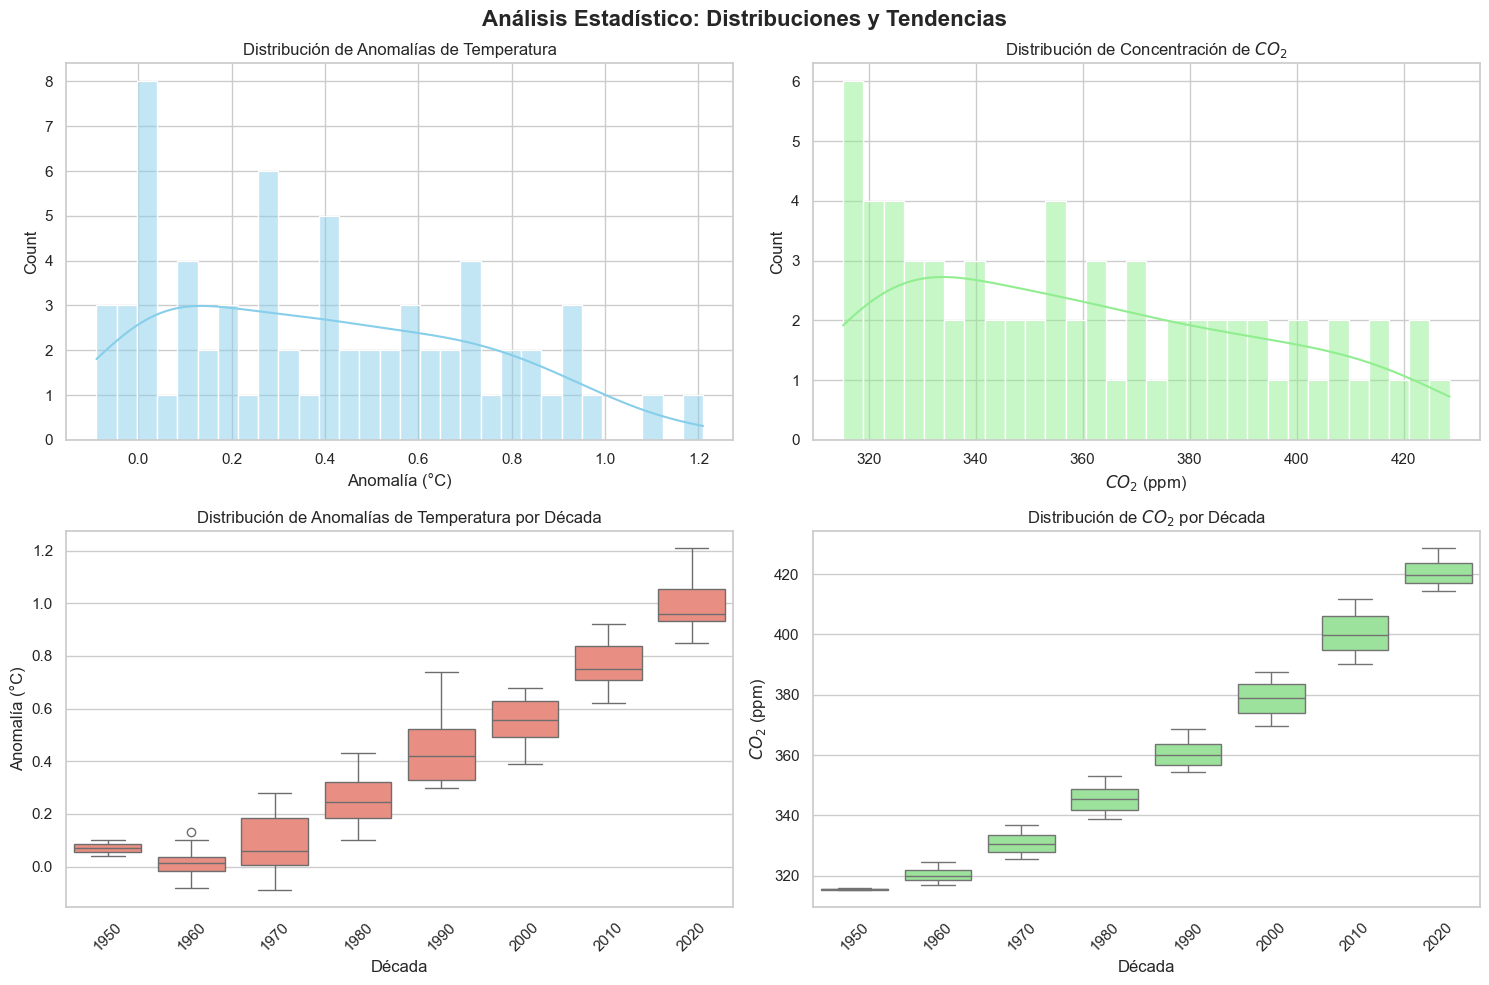

In [22]:
# Figura 2: Distribuciones y análisis estadístico
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Estadístico: Distribuciones y Tendencias', fontsize=16, fontweight='bold')

# Distribución temperatura
sns.histplot(data=df_comb, x='Anomaly', kde=True, color='skyblue', bins=30, ax=axes[0,0])
axes[0,0].set_title('Distribución de Anomalías de Temperatura')
axes[0,0].set_xlabel('Anomalía (°C)')

# Distribución CO2
sns.histplot(data=df_comb, x='co2_avg', kde=True, color='lightgreen', bins=30, ax=axes[0,1])
axes[0,1].set_title('Distribución de Concentración de $CO_2$')
axes[0,1].set_xlabel('$CO_2$ (ppm)')

# Boxplot por década - Temperatura
sns.boxplot(data=df_comb, x='decade', y='Anomaly', color='salmon', ax=axes[1,0])
axes[1,0].set_title('Distribución de Anomalías de Temperatura por Década')
axes[1,0].set_xlabel('Década')
axes[1,0].set_ylabel('Anomalía (°C)')
axes[1,0].tick_params(axis='x', rotation=45)

# Boxplot por década - CO2
sns.boxplot(data=df_comb, x='decade', y='co2_avg', color='lightgreen', ax=axes[1,1])
axes[1,1].set_title('Distribución de $CO_2$ por Década')
axes[1,1].set_xlabel('Década')
axes[1,1].set_ylabel('$CO_2$ (ppm)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

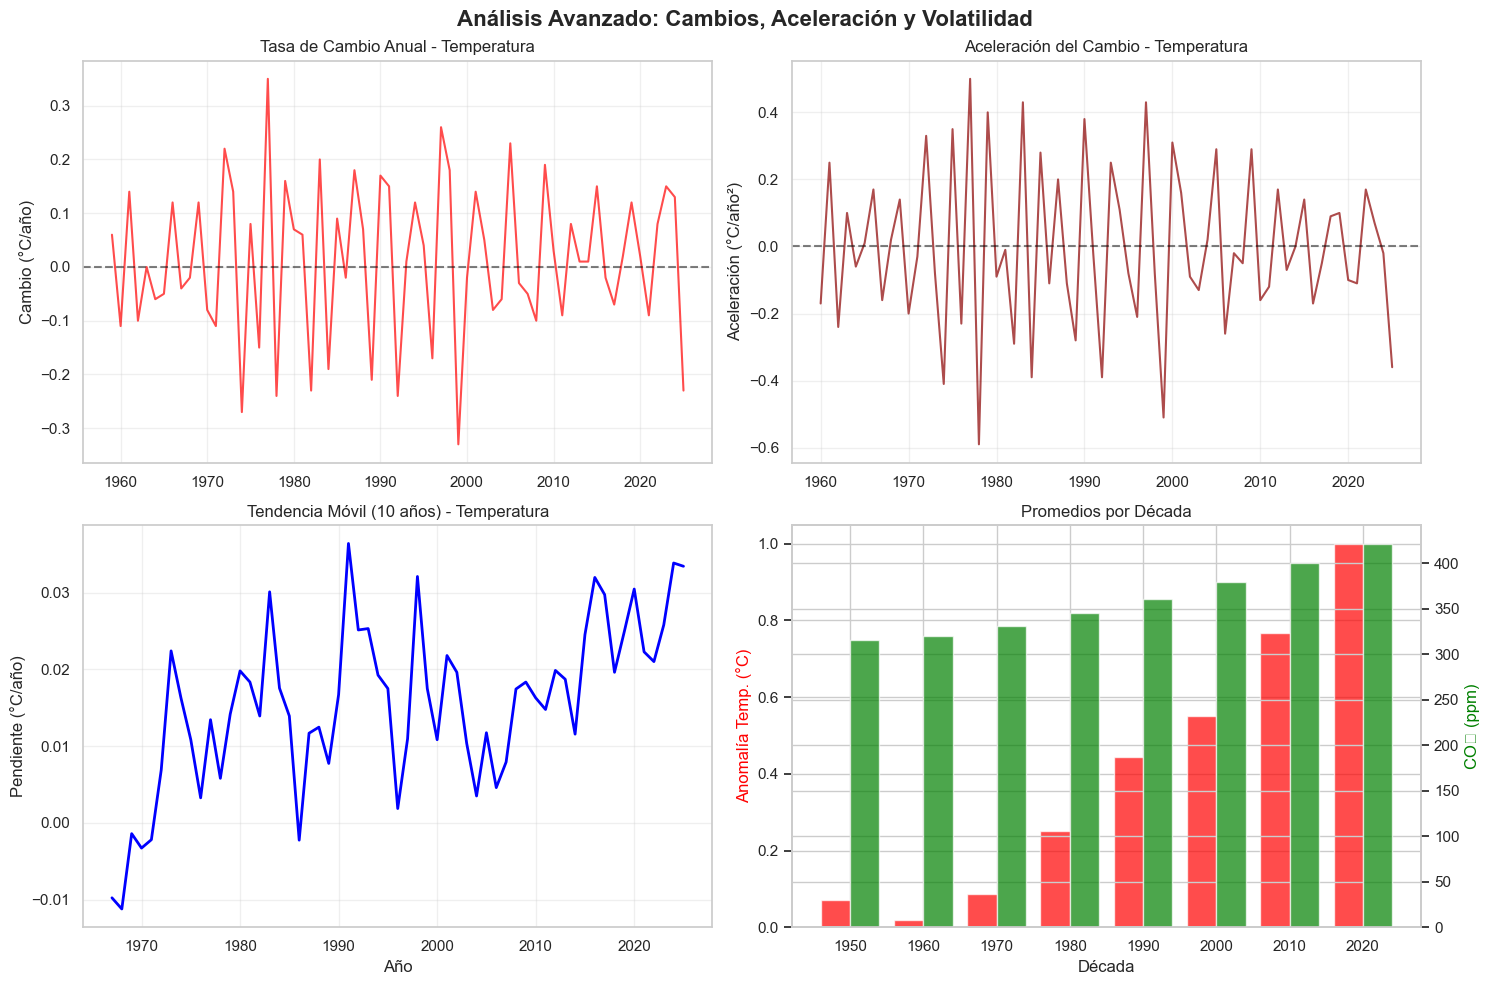

In [27]:
# Figura 3: Análisis avanzado de cambios
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Avanzado: Cambios, Aceleración y Volatilidad', fontsize=16, fontweight='bold')

# Tasas de cambio
axes[0,0].plot(df_comb['Year'], df_comb['temp_change'], color='red', alpha=0.7, linewidth=1.5)
axes[0,0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0,0].set_title('Tasa de Cambio Anual - Temperatura')
axes[0,0].set_ylabel('Cambio (°C/año)')
axes[0,0].grid(True, alpha=0.3)

# Aceleración
axes[0,1].plot(df_comb['Year'], df_comb['temp_acceleration'], color='darkred', alpha=0.7, linewidth=1.5)
axes[0,1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0,1].set_title('Aceleración del Cambio - Temperatura')
axes[0,1].set_ylabel('Aceleración (°C/año²)')
axes[0,1].grid(True, alpha=0.3)

# Tendencias móviles
axes[1,0].plot(df_comb['Year'], df_comb['temp_trend'], color='blue', linewidth=2)
axes[1,0].set_title(f'Tendencia Móvil ({window} años) - Temperatura')
axes[1,0].set_ylabel('Pendiente (°C/año)')
axes[1,0].set_xlabel('Año')
axes[1,0].grid(True, alpha=0.3)

# Promedios por década
decade_means = df_comb.groupby('decade').agg({
    'Anomaly': 'mean',
    'co2_avg': 'mean'
}).reset_index()

ax3 = axes[1,1]
ax4 = ax3.twinx()

bars1 = ax3.bar([d-2 for d in decade_means['decade']], decade_means['Anomaly'],
               width=4, color='red', alpha=0.7, label='Temp')
bars2 = ax4.bar([d+2 for d in decade_means['decade']], decade_means['co2_avg'],
               width=4, color='green', alpha=0.7, label='CO₂')

ax3.set_xlabel('Década')
ax3.set_ylabel('Anomalía Temp. (°C)', color='red')
ax4.set_ylabel('CO₂ (ppm)', color='green')
ax3.set_title('Promedios por Década')

plt.tight_layout()
plt.show()

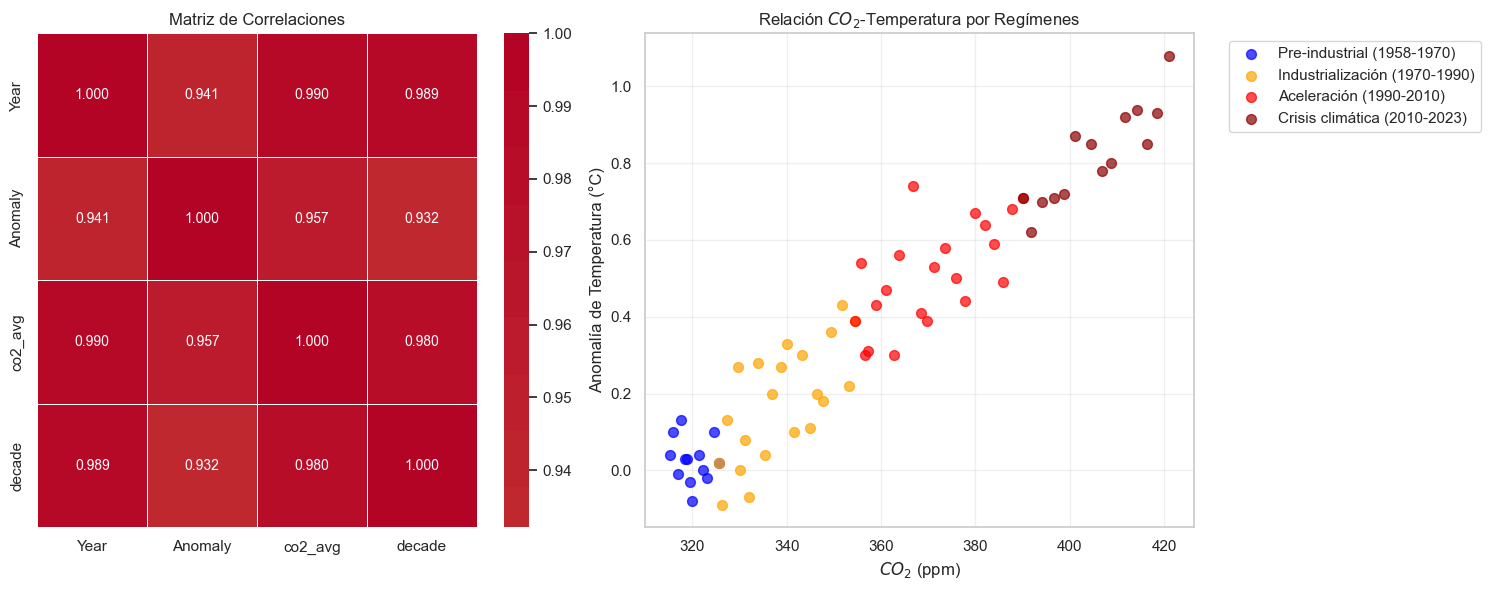

In [24]:
# Figura 4: Correlaciones y regímenes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap de correlaciones
corr_matrix = df_comb[['Year', 'Anomaly', 'co2_avg', 'decade']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', linewidths=0.5, ax=axes[0])
axes[0].set_title('Matriz de Correlaciones')

# Scatter por regímenes
colors = ['blue', 'orange', 'red', 'darkred']
for i, (period_name, (start, end)) in enumerate(periods.items()):
    period_data = df_comb[(df_comb['Year'] >= start) & (df_comb['Year'] <= end)]
    axes[1].scatter(period_data['co2_avg'], period_data['Anomaly'],
                        color=colors[i], label=period_name, alpha=0.7, s=50)

axes[1].set_xlabel('$CO_2$ (ppm)')
axes[1].set_ylabel('Anomalía de Temperatura (°C)')
axes[1].set_title('Relación $CO_2$-Temperatura por Regímenes')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#🔹 Si da >0.85, hay una fuerte correlación positiva
#🔸 Si da entre 0.5–0.8, es moderada pero consistente
#🔻 Si es muy baja (<0.3), no hay correlación clara

In [25]:
# ===============================================
# RESUMEN DE INSIGHTS CLAVE
# ===============================================

In [26]:
print("\n" + "="*60)
print("RESUMEN DE INSIGHTS CLAVE")
print("="*60)

# Calcular métricas clave
recent_temp_change = df_comb[df_comb['decade'] >= 2010]['temp_change'].mean()
early_temp_change = df_comb[df_comb['decade'] <= 1970]['temp_change'].mean()
recent_co2_change = df_comb[df_comb['decade'] >= 2010]['co2_change'].mean()
early_co2_change = df_comb[df_comb['decade'] <= 1970]['co2_change'].mean()

print(f"1. CORRELACIÓN PRINCIPAL:")
print(f"   - CO₂ vs Temperatura: {df_comb['Anomaly'].corr(df_comb['co2_avg']):.4f}")

print(f"\n2. ACELERACIÓN DEL CAMBIO:")
print(f"   - Cambio temp. reciente (2010+): {recent_temp_change:.4f}°C/año")
print(f"   - Cambio temp. histórico (≤1970): {early_temp_change:.4f}°C/año")
if early_temp_change != 0:
    print(f"   - Factor de aceleración: {recent_temp_change/abs(early_temp_change):.1f}x")

print(f"\n3. RÉGIMEN MÁS CRÍTICO:")
critical_regime = regime_df.loc[regime_df['temp_slope'].idxmax()]
print(f"   - Período: {critical_regime.name}")
print(f"   - Pendiente temperatura: {critical_regime['temp_slope']:.4f}°C/año")
print(f"   - Pendiente CO₂: {critical_regime['co2_slope']:.2f} ppm/año")

print(f"\n4. CORRELACIÓN TEMPORAL:")
best_lag = lag_df.loc[lag_df['correlation'].idxmax()]
print(f"   - Mejor correlación en lag {int(best_lag['lag'])}: {best_lag['correlation']:.4f}")

print(f"\n5. PUNTOS DE INFLEXIÓN:")
recent_peaks = df_comb.iloc[temp_peaks]['Year'].tail(3).tolist() if len(temp_peaks) > 0 else []
print(f"   - Últimos picos temperatura: {recent_peaks}")

print(f"\n6. DATOS PROCESADOS:")
print(f"   - Período analizado: {df_comb['Year'].min()}-{df_comb['Year'].max()}")
print(f"   - Total observaciones: {len(df_comb)}")
print(f"   - Variables creadas: {len(df_comb.columns)}")

# Guardar dataset final
df_comb.to_csv("../data/clean/df_comb_final.csv", index=False)
print(f"\n✅ Dataset final guardado: df_comb_final.csv")
print(f"✅ Listo para Fase 3: Modelado Predictivo")

print("\n" + "="*60)


RESUMEN DE INSIGHTS CLAVE
1. CORRELACIÓN PRINCIPAL:
   - CO₂ vs Temperatura: 0.9565

2. ACELERACIÓN DEL CAMBIO:
   - Cambio temp. reciente (2010+): 0.0187°C/año
   - Cambio temp. histórico (≤1970): 0.0076°C/año
   - Factor de aceleración: 2.5x

3. RÉGIMEN MÁS CRÍTICO:
   - Período: Crisis climática (2010-2023)
   - Pendiente temperatura: 0.0262°C/año
   - Pendiente CO₂: 2.44 ppm/año

4. CORRELACIÓN TEMPORAL:
   - Mejor correlación en lag 0: 0.9565

5. PUNTOS DE INFLEXIÓN:
   - Últimos picos temperatura: [2010, 2015, 2024]

6. DATOS PROCESADOS:
   - Período analizado: 1958-2025
   - Total observaciones: 68
   - Variables creadas: 10

✅ Dataset final guardado: df_comb_final.csv
✅ Listo para Fase 3: Modelado Predictivo

